#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

# Задача 1

---



По идее склерновские эмбединг векторайзеры типо того же tf idf делают всю это работу за нас?

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df = pd.read_csv('combined_data.csv')
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [7]:
stop_words = set(stopwords.words('english'))

def delete_stop_words(text: str):
  words = text.split(' ')
  clean_words = [word.lower() for word in words if word.isalpha() and (word.lower() not in stop_words)]
  return clean_words

In [8]:
df['text'] = df['text'].apply(delete_stop_words)

# Задача 2

---



Лемматизация - предение к исходной форме слова\
лучше - хорошо\
красивого - красивый\
Стеминг - обрезка слова до значимой его части (не обязательно семантически главного корня)\
Стеминг проще, но там есть две проблемы, с которыми мы не хотим столкнуться - недостаточная и излишняя обработка. Терять качество эмеддингов мы не хотим, сделаем лемматизацию с предобученной сеткой из nltk

In [9]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatization(text:list):
  return ' '.join([lemmatizer.lemmatize(w) for w in text]) #на вход тф айдиф нужны строки

df['text'] = df['text'].apply(lemmatization)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
df.sample(5)

,label,text
10443,0,author metze date escapenumber escapenumber es...
65844,0,start date hourahead hour hourahead schedule d...
77317,0,maruti september friday vince j kaminski hou e...
20717,1,great news mycanadianpharmacy announced half p...
17068,0,escapenumbers record following format host hos...


# Задача 3

---



In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val , y_train, y_val = train_test_split(
    df['text'], df['label'],
    test_size = 0.2, random_state=42,
    shuffle = True
    )

# Задача 4

---



Давайте прогоним тексты через BPEшку, в надежде качественно разбить на n-граммы. Все это нужно, что б мои эмбеденги (сумма ванхотов или тф айдиэф) не имели размерность 100000000 слов, а только пару тысяч n-грам.\
Звучит круто, посмотрим что получится))0))\
BPE взял по 1 ссылке от Hugging Face

In [12]:
!pip install tokenizers

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    vocab_size=3000,
    min_frequency=2,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)
tokenizer.train_from_iterator(X_train, trainer)

X_train = X_train.apply(tokenizer.encode)
X_val = X_val.apply(tokenizer.encode)

In [13]:
X_train = X_train.apply(lambda x: tokenizer.decode(x.ids))
X_val = X_val.apply(lambda x: tokenizer.decode(x.ids))

(Bad) Bag of words - сумма one hot векторов предложения\
tf idf - мера, вычисляющая tf * idf:\
 tf - частоту слова в документе (большая доля = важное слово для нас)\
 idf - частоту слова в корпусе (есть у всех документов - плохо)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_val_tf = tfidf.transform(X_val)

bag_of_words = CountVectorizer()
X_train_bad = bag_of_words.fit_transform(X_train)
X_val_bad = bag_of_words.transform(X_val)

# Задачи 5, 6

---



Чучуть потестив на модельках (***неожиданно***) bag of words показал себя хуже, можно заменить в логреге и проверить, оставлю только на tf idf

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

**Лог рег**

In [19]:
from sklearn.linear_model import LogisticRegression

params_logreg = {
    'C': np.logspace(-2,2,5),
    'penalty' : ['l2', None]
}
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

gs_logreg = GridSearchCV(
    LogisticRegression(), params_logreg,
    scoring = metrics, refit = 'accuracy' ,
    cv = 5, n_jobs=-1)

gs_logreg.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l2', None]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [107]:
best_model_index = gs_logreg.best_index_
for metric in metrics:
    print(f"{metric}: {gs_logreg.cv_results_['mean_test_' + metric][best_model_index]}")

accuracy: 0.9766020526846267
precision: 0.9737182955117923
recall: 0.9820808595252393
f1: 0.9778809540388375
roc_auc: 0.9965538254539694


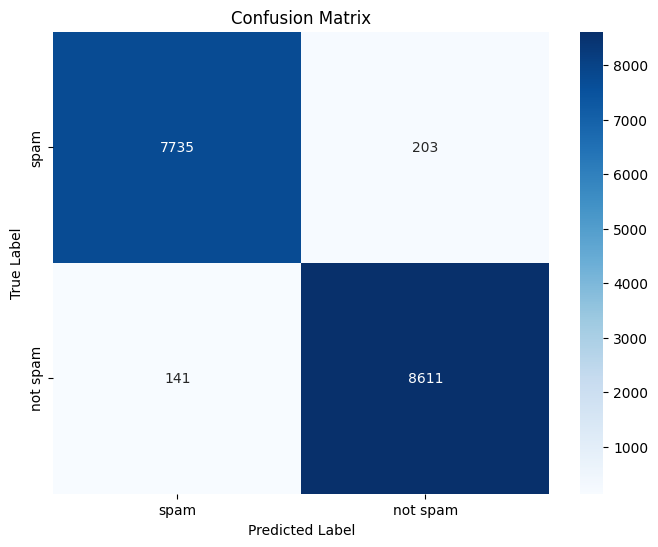

In [108]:
cm = confusion_matrix(y_val, gs_logreg.best_estimator_.predict(X_val_tf))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['spam', 'not spam'], yticklabels=['spam', 'not spam'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

**Случайный лес**

In [139]:
from sklearn.ensemble import RandomForestClassifier

params_les = {
    'max_depth' : [50, 20],
    'n_estimators' : [100, 50]
}

gs_les = GridSearchCV(
    RandomForestClassifier(), params_les,
    scoring = metrics, refit = 'accuracy' ,
    cv = 5, n_jobs=-1)

gs_les.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [50, 20], 'n_estimators': [100, 50]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [140]:
best_model_index_les = gs_les.best_index_
for metric in metrics:
    print(f"{metric}: {gs_les.cv_results_['mean_test_' + metric][best_model_index_les]}")

accuracy: 0.9749093696358615
precision: 0.9621280075389078
recall: 0.9913817509618139
f1: 0.9765357188642689
roc_auc: 0.9964995501848646


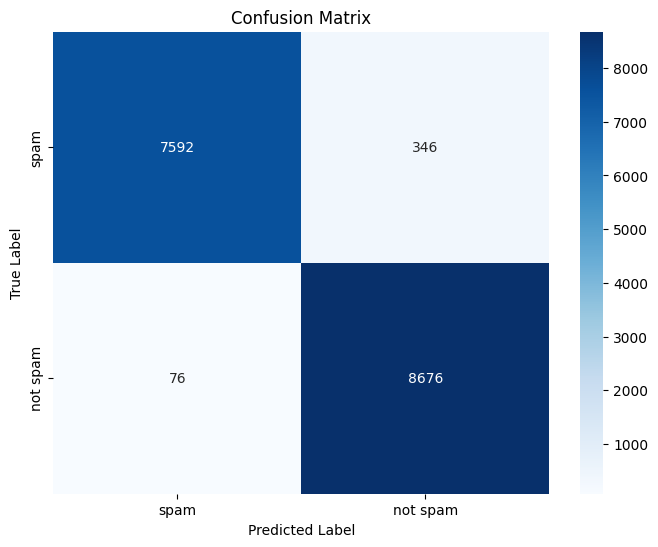

In [141]:
cm_les = confusion_matrix(y_val, gs_les.best_estimator_.predict(X_val_tf))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_les, annot=True, fmt='d', cmap='Blues', xticklabels=['spam', 'not spam'], yticklabels=['spam', 'not spam'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

**Catboost**

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


CatBoost тяжелая модель и мы не будем ее прогонять через gridsearch, очевидно, что нужно строить не очень глубокие деревья и как можно больше брать estimator`ов. А перебирать регуляризацию на 5 разбиениях для каждого из минимум 4 наборов параметров очень дорого для нас.

In [16]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

scores = {'accuracy': accuracy_score,
          'precision': precision_score,
          'recall': recall_score,
          'f1': f1_score,
          'roc_auc': roc_auc_score}

model = CatBoostClassifier(100, depth=7)
model.fit(X_train_tf, y_train)
for i in scores.keys():
  print(f"{i}: {scores[i](y_val, model.predict(X_val_tf))}")

Learning rate set to 0.5
0:	learn: 0.4328868	total: 2.76s	remaining: 4m 33s
1:	learn: 0.3390255	total: 4.51s	remaining: 3m 41s
2:	learn: 0.2939992	total: 6.75s	remaining: 3m 38s
3:	learn: 0.2601229	total: 9.57s	remaining: 3m 49s
4:	learn: 0.2312508	total: 11.5s	remaining: 3m 38s
5:	learn: 0.2129310	total: 13.2s	remaining: 3m 26s
6:	learn: 0.2001605	total: 14.8s	remaining: 3m 16s
7:	learn: 0.1878103	total: 16.4s	remaining: 3m 8s
8:	learn: 0.1765223	total: 18.2s	remaining: 3m 3s
9:	learn: 0.1675528	total: 19.7s	remaining: 2m 57s
10:	learn: 0.1603976	total: 22.1s	remaining: 2m 58s
11:	learn: 0.1526905	total: 25s	remaining: 3m 3s
12:	learn: 0.1474890	total: 26.7s	remaining: 2m 58s
13:	learn: 0.1434384	total: 28.3s	remaining: 2m 53s
14:	learn: 0.1395965	total: 29.9s	remaining: 2m 49s
15:	learn: 0.1350942	total: 31.4s	remaining: 2m 44s
16:	learn: 0.1320287	total: 33s	remaining: 2m 41s
17:	learn: 0.1281271	total: 34.6s	remaining: 2m 37s
18:	learn: 0.1245717	total: 36.9s	remaining: 2m 37s
19:	

Очевидно, что бустинг очень хорош и если подобрать параметры можно и 99 добиться, но не будем 10 часов обучать на CPU, как сказано в условии


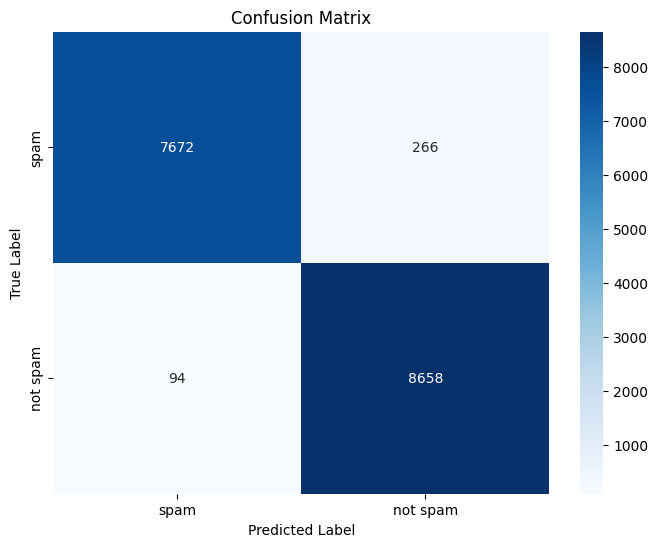

In [17]:
cm_boost = confusion_matrix(y_val, model.predict(X_val_tf))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_boost, annot=True, fmt='d', cmap='Blues', xticklabels=['spam', 'not spam'], yticklabels=['spam', 'not spam'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

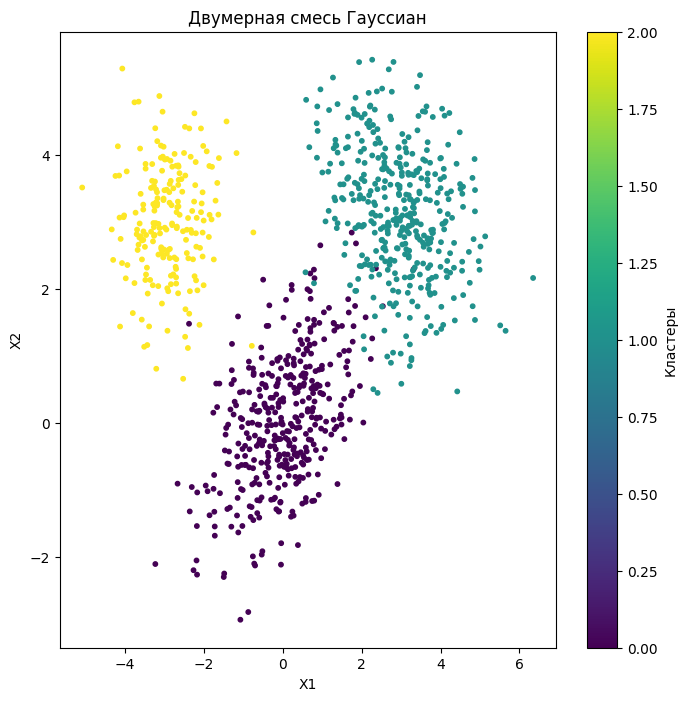

In [30]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def silhouette_scorer(estimator, X):
    pred = estimator.fit_predict(X)
    return silhouette_score(X, pred)

classterizator = KMeans()
params = {
    'n_clusters' : list(map(int, np.linspace(2,10, 9))),
    'init': ['k-means++', 'random']
}
kmeans = GridSearchCV(classterizator, params, scoring=silhouette_scorer, cv = 8)
kmeans.fit(X)
kmeans.cv_results_

{'mean_fit_time': array([0.00353077, 0.00371391, 0.00688186, 0.00549474, 0.00670564,
        0.0161075 , 0.01665407, 0.00709575, 0.00565487, 0.00942376,
        0.01286814, 0.01305529, 0.01730222, 0.01959482, 0.01978189,
        0.02067202, 0.02182159, 0.02327812]),
 'std_fit_time': array([0.00028946, 0.00026639, 0.0032489 , 0.00097157, 0.00162036,
        0.00673976, 0.00684772, 0.00381548, 0.00142475, 0.00131933,
        0.00204775, 0.00129884, 0.00241294, 0.00142941, 0.00219327,
        0.00292705, 0.00336654, 0.00267232]),
 'mean_score_time': array([0.00611621, 0.00611365, 0.0090628 , 0.0068979 , 0.0078505 ,
        0.01903296, 0.02054504, 0.00635865, 0.00552878, 0.00904918,
        0.01147503, 0.01056153, 0.01098648, 0.01362264, 0.0108507 ,
        0.0114038 , 0.01058751, 0.0121612 ]),
 'std_score_time': array([0.0011976 , 0.00052572, 0.00488735, 0.00052656, 0.00208423,
        0.00801441, 0.00417198, 0.0033464 , 0.00120112, 0.00102366,
        0.00179775, 0.00122534, 0.00076083, 

Че то он криво выбирает лучшего, видим лучший по параметрам 2 эстимейтор - 3 кластера, k++

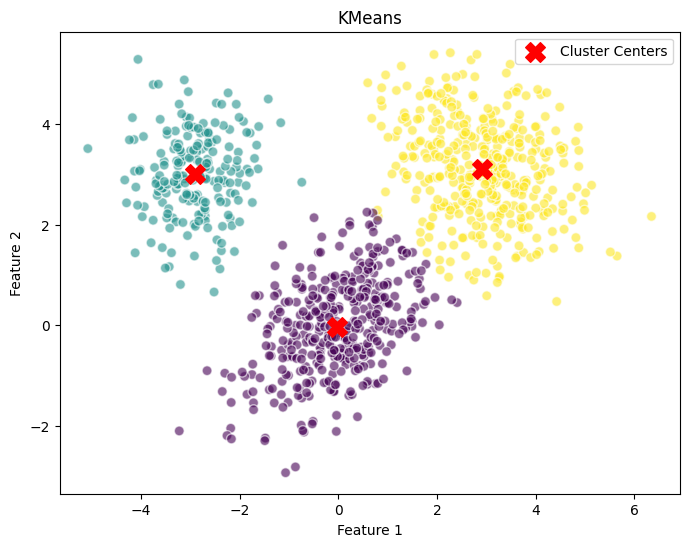

In [41]:
best = KMeans(init= 'k-means++',n_clusters= 3)
best.fit(X)
labels = best.labels_
centers = best.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Cluster Centers')

plt.title("KMeans")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.